# Initialization

In [ ]:
# using Pkg
# Pkg.add(["Plots", "Plotly", "WAV", "FFTW", "Wavelets", "LinearAlgebra"])

In [12]:
using Plots, WAV, FFTW, Wavelets, LinearAlgebra

# audio playing with the wavplay function is not support for Windows and it does not work in the binder environment 

# uncommnet this for audio playing functionality on Linux
# include("./assets/wavplay-pulse.jl")

# uncommnet this for audio playing functionality on macOS
include("./assets/wavplay-audioqueue.jl")

# set up default parameters for plots 
gr(size=(800,400), lw = 2, lc = :black)

# enable plotly backend if you want interactive plots
# plotly(size=(800,300), lw = 2, lc = :black)

Plots.GRBackend()

# What is a Wavelet

In order to understand what a wavelet is, it is recommened to have some experience with the Fourier Transform. A wavelet is a wave oscillation localized in time, this means that is it finite instead of the sine and cosine waves of the Fourier Transform that are infinate. You can see an example in the following plot.

![](./assets/wavelet1.jpg)

The word _wavelet_ is derived from the French word *ondelette*, meaning _small wave_ and that is exactly what a wavelet it. But how can it be used to extract the underlying frequency components of a wave ? In the Fourier Transform a signal $g(t)$ is compared against sine and cosine waves of different frequencies, this is not far from how the Wavelet Transform works. Instead of trying different frequencies, the Wavelet Transform alters two wavelet parameters called _scale_ and _shift_ (or *translation*). The _scale_ parameter affects the length of the wave and consequently the frequency that it matches. A larger scale means a lower frequency and a smaller scale translates to a higher frequency. The _shift_ parameter affects the wavelet's position in the time dimension, a lower or higher shift means that the wave will occur sooner or later respectively.  
When learning about wavelet analysis you will also see the term *Mother Wavelet*, this refers to a wavelet that its parameters have not been altered. For example in the image of section 2.1 all the wavelets are mother wavelets because they appear with their default parameters.

## Families of Wavelets

Wavelets come in different shapes and sizes. In fact, the availability of a wide range of wavelet families is a key strength of wavelet analysis. The choice of wavelet family depends on the application you are going to use it for. Additionally almost all wavelet families contain a lot of predefined wavelets! Some of the most well known wavelet families are presented in the following image. The first row contains continuous wavelet families and the second one discrete. The difference of the Continuous and Discrete Wavelets is explained in section 3.1 .

![](./assets/wavelet_families.png)  

# The General Wavelet Transform Equation

The General Wavelet Transform Equation is the following
$$\large X_{a,b} = \frac{1}{\sqrt{a}} \int_{-\infty}^{\infty} \! x(t) * \psi_{a,b}(t) \, \mathrm{d}t $$
and is very similar to the Fourier Transform. As a reminder the Fourier Transform equation is $$\large \hat{X}(t) = \int_{-\infty}^{\infty} \! x(t) * e^{-2\pi * i * f * t} \, \mathrm{d}t $$  
These equations work the same way. Namely, we have a signal $X(t)$ which we multiply with a wave of different properties and then the integral. This allows us to quantitatively measure the similarity of the signal $g(t)$ with a wave.  
In the Wavelet Transform equation the $\psi_{a,b}(t)$ refers to an arbitrary wavelet function with scale $a$ and shift $b$. For the example $\psi$ could be the Morlet Wavelet whose equation is:
$$\large \psi_{a,b}(t) = e^{-\frac{t^2}{2}} * cos(5t)$$

## Continuous and Discrete Wavelet Transforms

When diving into Wavelet Analysis and Wavelet Theory something that often causes confusion is the difference between the Continuous Wavelet Transform (CWT) and the Discrete Wavelet Transform (DWT). This is due to the badly named *Continuous* Wavelet Transform. It is important to clarify that both the CWT and DWT are discrete and can be applied to discrete sampled signals. Their difference being that the *scale* and *shift* parameters in the CWT can take on non-integer values, but this fact does not make it Continuous in the mathematical sense. In the DWT case the scale parameters increases in powers of 2 and the shift takes on only integer values.  

# Why use the Wavelet Transform ?

One of the most important advantages of the Wavelet Transform is that it keep both frequency and time information. In contrast, the Fourier Transform can represent a signal in the frequency domain but not in the time domain. This deficiency can be especially important when analyzing non-stationary signals in which frequency changes over time.  

In the following cells we showcase this ues case, firstly we define some helper functions for creating a non-stationary signal and transforming it to the frequency domain. Then we generate signals and compare the output of the fourier transform of a stationary and a non-stationary signal.

In [13]:
function sin_wave(frequency,amplitude,fs,τ)
    #=
    frequency: cycles per second
    amplitude: multiplier to the sin
    fs:        samples per second
    τ:         total time duration of the wave
    =#
    xs = range(0, τ, length=τ*fs)
    amplitude * sin.(2pi * frequency * xs) # last value is returned automatically
end

multi_sin_wave(freqs, ampl, fs, τ) = sin_wave.(freqs, ampl, fs, τ) |> (x->vcat(x...))

function frequency_domain(y, fs)
    y_fft = fft(y) .|> abs
    y_fft = y_fft[1:Int64(length(y) / 2) + 1] / length(y)
    y_fft[2:end-1] *= 2
    freqs = range(0, fs / 2, step = fs / length(y))
    (freqs, y_fft)
end

frequency_domain (generic function with 1 method)

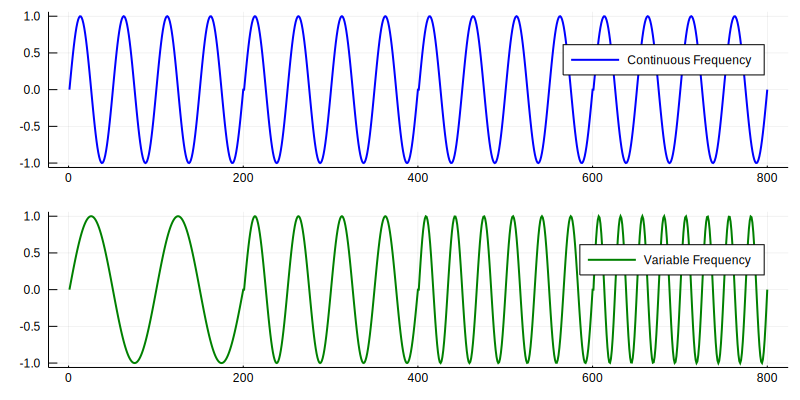

In [14]:
fs = 100
y_cont = multi_sin_wave([2,2,2,2], [1,1,1,1], fs, [2,2,2,2])
y_var = multi_sin_wave([1,2,3,4], [1,1,1,1], fs, [2,2,2,2])

plot([y_cont, y_var], layout = (2,1), lab = ["Continuous Frequency" "Variable Frequency"], lc = [:blue :green])

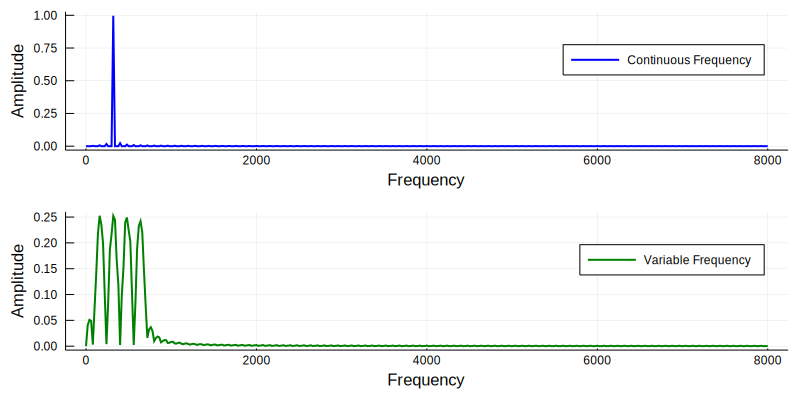

In [23]:
fft_cont, fft_var = frequency_domain.([y_cont, y_var], fs)
plot([fft_cont[1], fft_var[1]], [fft_cont[2], fft_var[2]], layout = (2,1), xlabel = "Frequency", ylabel = "Amplitude", lc = [:blue :green], lab = ["Continuous Frequency" "Variable Frequency"])

It is obvious from the above plot that the Fourier Transform falls short on non-stationary signals even in this low complexity case where the signal does not vary much frequency-wise. Let's see how the Continuous Wavelet Transform using the Morlet wavelet performs in this task. In the cell below we plot a Scaleogram using the output of the CWT.

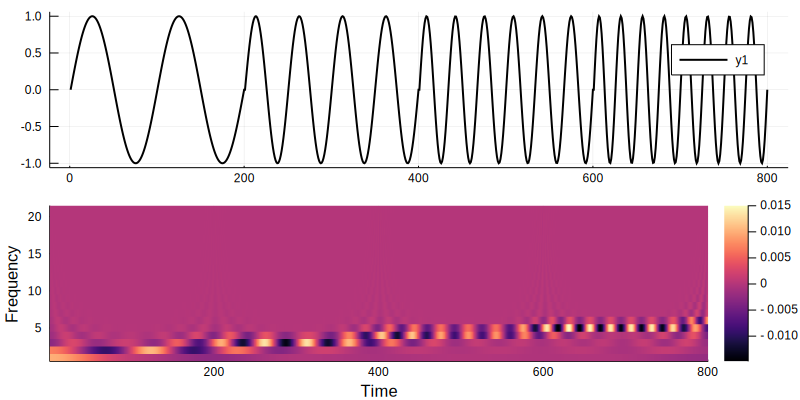

In [16]:
# applies CWT and plots scaleogram and the variable frequency signal
let y = y_var, wt = WT.morl
    yt = cwt(y, wavelet(wt))
    yt = reshape(yt, size(yt, 1), size(yt, 2))
    # we will make use of the heatmap plot type in order to plot the scaleogram
    hm = heatmap(real.(yt)', xlabel="Time", ylabel="Frequency", colorbar=true, color=:magma) 
    p = plot(y)
    plot(p, hm, layout = (2,1)) # plot the subplots in a 2x1 layout
end

In the scaleogram above we can see that the CWT not only correctly identifies the variable frequency but also identifies how the frequency evolves over time.

## Short Note on the Short Time Fourier Transform

It is important to note that researchers have developed the Short Time Fourier Transform (STFT) to make the Fourier Transform viable in the aforementioned scenario. This method splits the signal into smaller sub-signals using a window size and then performs Fourier Transform on these windows. However problems arise when the window size is too small or too large. In the first case frequency accuracy takes a hit because in the Fourier Transform, the longer a frequency repeats the stronger the accuracy gets. In the second case, time information is lost resulting in less localized and more crude results.

# Application: Signal Denoising

In this section we are going to experiment with signal denoising. Firstly we will plot a scaleogram of the *joe.wav* audio signal. Then we will add noise to the signal and use the Discrete Wavelet Transform with the Symlet 5 wavelet (more info about this wavelet [here](http://wavelets.pybytes.com/wavelet/sym5/])) in order to denoise it.

In [17]:
y, fs, _, _ = wavread("./assets/joe.wav"); # load the audio file

In [18]:
yt = cwt(y, wavelet(WT.morl)); # apply the Cointinuous Wavelet Transform with the Morlet Wavelet
yt = reshape(yt, size(yt, 1), size(yt, 2)); # reshapre the 3d array to 2d, this is needed only for this particular implementation of the cwt function

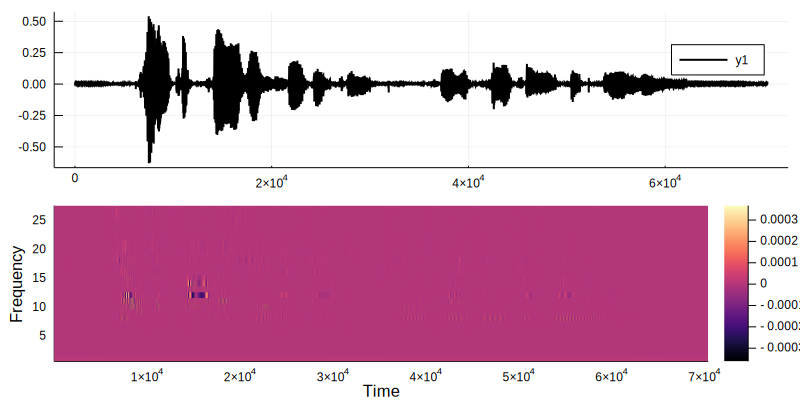

In [19]:
# we will make use of the heatmap plot type in order to plot the scaleogram
# note that we only use the real components of the cwt, the imaginary units are very close to 0 and contain very little information
ht = heatmap(real.(yt)', xlabel="Time", ylabel="Frequency", colorbar=true, color=:magma)
p = plot(y)
plot(p, ht, layout = (2,1))

In [22]:
# WARNING! LOWER YOUR VOLUME BEFORE RUNNING THIS
let noise = 0.05
    yn = y .+ noise * randn(length(y)); # add random noise to the signal
    wavplay(yn, fs)
    #= here we will use the denoise function with the default Symlet 5 wavelet. The denoise function
    uses the Discrete Wavelet Transfrom and as a result the signal length must be a power of 2.
    The closest power of 2 to our signals real length (70393) is 65536 and thus we will cut it there.=#
    dyn = denoise(vec(yn)[1:65536], TI=true) # the vec function converts the 2d array to 1d
    wavplay(hcat(dyn), fs) # the hcat function converts the 1d array to 2d for playback
    plot([y, yn, dyn], layout = (3,1), lab = ["Clean Signal" "Noisy Signal" "Denoised Signal"], 
        lc = [:red :green :blue], size = (900, 700))
end

As you can hear, the DWT really helped reducing the noise. But it also distorted some of the audio. The volume is very low in some parts which make them almost inaudible. The value of 0.05 in the noise parameters adds very much noise, a lower noise value would lead to less distortion. The signal plot also gives us some insight into which parts of the audio are lost when the audio is recreated. Parts with lower amplitude are more affected and are mostly lost, while parts with higher amplitude are more resilient.  
I encourage you to try out different noise values and see (and hear) the results!